Key metrics to monitor success of team's effort in improving the guest host matching process?

Goal of the company:
- increase bookings on platform

Ideas:
- contact to booking ratio
- listings to booking ratio
- interactions before booking

# Import Required Python Packages and Define Functions

## Required Packages

In [1]:
# Import required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time # For measuring performance time of functions
import matplotlib.pyplot as plt # For basic quick plotting
import seaborn as sns # For creating stylized figures

## Define Common Functions

In [2]:
def dataframe_overview(df,df_name):
    '''
    This function presents an overview of the DataFrame
    
    Input
    -----
    df: a DataFrame object
    df_name: a string containing the name of the DataFrame object
    
    Output
    ------
    Print out overview for provided DataFrame
    '''
    
    # Define variables to use in print out
    # Number of null values
    null_cells = df.isna().sum().sum()
    # Number of rows that contain null values in any column
    null_rows = df.isna().any(axis = 1).sum()
    # Number of cells (rows in DataFrame multiplied by columns in DataFrame)
    df_cells = df.shape[0] * df.shape[1]
    
    # Apply variables in print statements
    print(f"Overview statistics for {df_name}:")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    
    print(f"Number of rows with null values in any column: {null_rows}")
    print(f"% of rows with null values in any column: {np.round(null_rows/df.shape[0] *100,2)}%")
    
    print(f"Number of null cells: {null_cells}")
    print(f"% of cells with null values: {np.round(null_cells/df_cells *100,2)}%")

In [3]:
def categorical_value_count(df, col):
    '''
    Performs value counts for each catgory given a categorical column
    
    Usage
    -----
    Used throughout the notebook to understand the distribution of categorical variables and to confirm the ratio of the target variable.
    
    Input
    -----
    df  : DataFrame that contains the categorical column
    col : Categorical column to perform value counts on
    
    Output
    ------
    Prints a DataFrame that contains the categories, value counts for each category, and the % of total rows for each category
    
    Examples
    --------
    Given DataFrame 'df1' and categorical column 'col1':
    
    categorical_value_count(df1,'col1')
    
    '''
    # Creates a temporary DataFrame which stores the flatted value_count table generated by the value_counts method
    temp_df               = df[col].value_counts(dropna = False).rename_axis(col).reset_index(name = 'Counts')
    
    # Adds a new column which calculates the % of total for each row in the temporary DataFrame
    temp_df['% of total'] = round(temp_df['Counts']/df.shape[0]*100,2)
    
    # Return the DataFrame
    return temp_df

In [4]:
def plot_distribution(df, col):
    '''
    Plots 2 subplots: 
    Left subplot: histogram without any transformation. The mean and median lines were included.
    Right subplot: histogram with LOG transformation and on LOG scale. The mean and median lines were included.
    
    Usage
    -----
    Used in the EDA section to determine skewed distributions with outliers, and to determine if LOG should be applied to center skewed distributions and deal with outliers without dropping rows
    
    Input
    -----
    df  : DataFrame that contains the continuous numerical column
    col : Categorical column to plot distribution 
    
    Output
    ------
    Two subplots of histogram, left without transformation and right with LOG transformation
    
    Examples
    --------
    Given DataFrame 'df1' and categorical column 'col1':
    
    plot_distribution(df1,'col1')
    
    '''
    # Start timer
    start = time.perf_counter()
    print(f"===== Distribution Plots for {col} =====")
    
    # Calculate number of null values in specific column
    null_values = df[col].isna().sum()
    
    # Print out the percentage of null values in column
    print(f"Number of null values in {col}: {null_values}")
    # Note that a pandas series, not a dataframe, was created, explaining shape with index 0
    print(f"% null values in {col}: {np.round(null_values / df[col].shape[0] * 100,2)}%")
    
    # Create subplot object with 1 row and 2 columns
    plt.subplots(1, 2, figsize = (15,5))

    # Calculate the summary statistics for column
    col_mean = np.mean(df[col])
    col_median = np.median(df[col].dropna()) # drop null values before calculating median

    # Plot first histogram to show distribution as is
    plt.subplot(1,2,1)
    sns.histplot(data = df, x = col, stat = 'probability');
    plt.axvline(col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(col_mean,2)}")
    plt.axvline(col_median, linestyle = '--', c = 'red', label = f"median: {np.round(col_median,2)}")
    plt.legend()
    plt.title(f"Distribution for {col}")

    # Plot second histogram to show log distribution
    # Calculate log of column
    log_df = np.log(df+1)
    log_col_mean = np.mean(log_df[col])
    log_col_median = np.median(log_df[col].dropna())

    # Plot second histogram to show LOG distribution
    plt.subplot(1,2,2)
    sns.histplot(data = log_df, x = col, stat = 'probability');
    plt.axvline(log_col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(log_col_mean,2)}")
    plt.axvline(log_col_median, linestyle = '--', c = 'red', label = f"median: {np.round(log_col_median,2)}")
    plt.xlabel(f"LOG {col}")
    plt.legend()
    plt.title(f"LOG Distribution for {col}")

    sns.despine()
    plt.show()
    
    # End timer 
    end = time.perf_counter()
    print(f"Time taken : {np.round(end - start,3)} seconds.")
    print(f"===============================================")
    print(f"")
    print(f"")

# Import Data

## Main Data - Booking Inquiries (Contacts)

**Contacts.csv**, in which each row represents an inquiry for a stay at a listing in Rio de Janeiro, was loaded into the DataFrame **contacts_df**. Contacts_df was identified as the main table (central table within a star schema) as it contains information regarding each inquiry, which is essential to measuring the performance of the team in Rio de Janeiro and AirBnB in general. This is because the conversion of an inquiry into a booking is what generates income for AirBnB.

### Load Data and Overview

In [5]:
# contacts_df: contains a row for everytime a user makes an inquiry for a stay at a listing in Rio de Janeiro
contacts_df = pd.read_csv(
    'data/contacts.csv', 
    # The columns that are datetime or date objects based on provided data dictionary were passed into the parse_dates argument
    parse_dates = [
        'ts_interaction_first', # UTC timestamp of the moment the inquiry is made
        'ts_reply_at_first', # UTC timestamp of the moment host replies to inquiry, if so
        'ts_accepted_at_first', # UTC timestamp of the momentt host accepts the inquiry, if so
        'ts_booking_at', # UTC timestamp of the moment the booking is made, if so
        'ds_checkin_first', # timestamp of the checkin date of inquiry
        'ds_checkout_first' # timestamp of the checkout date of inquiry
    ]
)

The data available contained a total of 27,887 inquiries. Although 58.45% of the inquiries contained a null value, the null value may indicate an inquiry that resulted in no booking and requires further data exploration. To affirm the previous statement, only 7.63% of all cells were null, further supporting the need to explore the columns deeply.

In [6]:
# Examine the overview for the loaded data
dataframe_overview(contacts_df, "contacts_df")

Overview statistics for contacts_df:
Number of rows: 27887
Number of columns: 14
Number of rows with null values in any column: 16300
% of rows with null values in any column: 58.45%
Number of null cells: 29805
% of cells with null values: 7.63%


Below is a visual printout of the first 5 rows of the data within *contacts_df*. To present the data in a more readable matter, the data was presented in a transposed format, where each row below is a data field and each column is an inquiry.

Upon visual examination, the 3 data fields that begin with *'id'* are useful for identifying unique inquiries within *contacts_df* and are useful for connecting to supporting data tables *listings_df* and *users_df*.

Some cells below were observed to contain 'NaT', which stands for *Not a Time*. This means that there were null values or objects in the cells that cannot be recognized as datetime objects by the pandas module. However, this is not a problem in the data and should instead be understood as a inquiry that did not become a booking or an `instant_book` inquiry, in which no response or confirmation is needed from the host.

In [7]:
# Visually examine first 5 rows of data
display(contacts_df.head().T)

,0,1,2,3,4
id_guest_anon,da8656a1-51af-4f38-b1c4-94be1f585157,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,b0af8848-fe2a-4ef1-991e-26ab3066feb3,5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2
id_host_anon,5426897d-960d-4013-9e38-606ae746793c,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,13cbf50a-3272-45d4-9866-a06b6ea1b99a,01614601-d5a4-4776-ab9b-c10d3b865bf0,f2fed6f3-4c5c-453d-9e64-37c62b8bd06d
id_listing_anon,a408a8b2-0d44-4513-a611-3736d0409bb2,e387c705-0aeb-464c-9375-ece63be6f006,d1eb1960-938f-4305-a353-51e224414dd4,855f6779-346c-45fc-a64b-ea133250ca7a,f2928a59-c5e7-42b2-9c37-240a40f38dc0
ts_interaction_first,2016-04-21 02:55:53,2016-02-16 22:14:01,2016-01-27 23:33:38,2016-05-05 14:42:52,2016-06-23 03:09:25
ts_reply_at_first,2016-04-21 03:15:00,2016-02-16 23:37:36,2016-01-28 02:12:47,2016-05-05 15:17:40,2016-06-23 03:09:26
ts_accepted_at_first,2016-04-21 03:15:00,NaT,NaT,2016-05-05 15:17:40,2016-06-23 03:09:33
ts_booking_at,2016-04-21 03:15:00,NaT,NaT,NaT,2016-06-23 03:09:33
ds_checkin_first,2016-08-02 00:00:00,2016-08-11 00:00:00,2016-03-14 00:00:00,2016-05-27 00:00:00,2016-08-19 00:00:00
ds_checkout_first,2016-08-06 00:00:00,2016-08-22 00:00:00,2016-03-23 00:00:00,2016-05-29 00:00:00,2016-08-21 00:00:00
m_guests,4.0,5.0,1.0,2.0,3.0


### Duplicated Inquiries

In [8]:
# Create a combination of the three id columns to check for unique values
if contacts_df.duplicated(subset = ["id_guest_anon", "id_host_anon", "id_listing_anon"]).sum()==0:    
    print("The combination of id columns form a unique identifier for each AirBnB inquiry.")
else:
    print("The combination of id columns do not form a unique identifier for each AirBnB inquiry.")

The combination of id columns do not form a unique identifier for each AirBnB inquiry.


Further examine the duplicated rows to examine why there are duplicates for the id columns.

In [9]:
# Create a condition to identify rows with duplicated id columns
cond1 = contacts_df.duplicated(
    subset = ["id_guest_anon", "id_host_anon", "id_listing_anon"],
    keep = False)

# Apply the condition and sort data to visually examine why there are duplicated id columns
contacts_df[cond1].sort_values(
    by = ['id_guest_anon', 'id_host_anon', 'id_listing_anon', 'ds_checkin_first'],
    ascending = [False,  False, False, True]).head(5)

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first
7308,fe9822af-9343-4577-b785-ccb8837ab331,e67ac00d-5f7f-47f3-b65c-133846a91cf0,0f68b6b9-53a9-4c85-a543-264fe4118277,2016-04-24 02:20:07,2016-04-24 02:20:08,2016-04-24 02:20:08,2016-04-24 02:20:08,2016-07-31,2016-08-01,1.0,2,115.0,instant_book,past_booker
18946,fe9822af-9343-4577-b785-ccb8837ab331,e67ac00d-5f7f-47f3-b65c-133846a91cf0,0f68b6b9-53a9-4c85-a543-264fe4118277,2016-04-24 02:24:50,2016-04-24 02:24:51,2016-04-24 02:24:51,2016-04-24 02:24:51,2016-08-20,2016-08-22,1.0,16,63.0,instant_book,past_booker
5426,fa7be6b9-85bd-492d-8c56-5f30c24629da,3429cbcd-ab0d-43ec-8be2-40941f58098a,9e8c83c6-091d-40fc-8bb4-95fde8e0e15c,2016-03-18 01:08:59,2016-03-18 01:09:00,2016-03-18 01:09:00,2016-03-18 01:09:00,2016-06-18,2016-06-19,2.0,5,0.0,instant_book,past_booker
5714,fa7be6b9-85bd-492d-8c56-5f30c24629da,3429cbcd-ab0d-43ec-8be2-40941f58098a,9e8c83c6-091d-40fc-8bb4-95fde8e0e15c,2016-03-17 01:42:51,2016-03-17 01:42:51,2016-03-17 01:42:51,2016-03-17 01:42:51,2016-07-23,2016-07-24,2.0,15,0.0,instant_book,past_booker
8983,fa7be6b9-85bd-492d-8c56-5f30c24629da,3429cbcd-ab0d-43ec-8be2-40941f58098a,9e8c83c6-091d-40fc-8bb4-95fde8e0e15c,2016-03-18 01:23:48,2016-03-18 01:23:48,2016-03-18 01:23:48,2016-03-18 01:23:48,2016-07-26,2016-08-06,2.0,19,0.0,instant_book,past_booker


In the first two rows, the guest starting with `fe9822af` was observed to make repeated bookings with the host starting with `e67ac00d` for the same listing starting with `0f68b6b9`. Observing the `ds_checkin_first` column, the duplicated id columns were due to the same guest making multiple bookings with the same host for the same listing for multiple future check-ins. 

Thus, this observation reveals that the customer is satisfied with the listing to confirm further bookings through the AirBnB application, and can be used as a measure of success in terms of returning customers.

Following up the original intention of using the id columns to identify unique bookings, assuming that:
- repeated inquiries can be made from the same guest to the same host for the same listings 
- if a listing has multiple of the same units, the guest can have multiple inquiries with the same check-in dates

Unique bookings can be identified by adding the `ts_interaction_first` column.

In [10]:
# Create a combination of the three id columns to check for unique values
if contacts_df.duplicated(subset = ["id_guest_anon", "id_host_anon", "id_listing_anon", "ts_interaction_first"]).sum()==0:
    print("The combination of id and interaction date columns form a unique identifier for each AirBnB inquiry.")
else:
    print("The combination of id and interaction date columns do not form a unique identifier for each AirBnB inquiry.")

The combination of id and interaction date columns form a unique identifier for each AirBnB inquiry.


## Supporting Data - Listings and Users

### Listings

#### Load Data and Overview

Two supporting data files: `Listings.csv` and `Users.csv` were provided. Similar to `contacts_df`, the 

In [11]:
# Importing the data for every listing
listings_df = pd.read_csv('data/listings.csv')

**Listings.csv** contains data for every listing in the market.

In [12]:
# Examine the overview for the loaded data
dataframe_overview(listings_df, "listings_df")

Overview statistics for listings_df:
Number of rows: 13038
Number of columns: 4
Number of rows with null values in any column: 0
% of rows with null values in any column: 0.0%
Number of null cells: 0
% of cells with null values: 0.0%


No null values for listings_df. Visual inspection revealed that the some listings have an unknown neighborhood. This might be due to some listings being in between neighbourhoods or that the host did not specify a neighourhood.

In [13]:
# Visual inspection of the first 5 rows of listings data table
listings_df.head()

,id_listing_anon,room_type,listing_neighborhood,total_reviews
0,71582793-e5f8-46d7-afdf-7a31d2341c79,Private room,-unknown-,0.0
1,a1a3f728-e21f-4432-96aa-361d28e2b319,Entire home/apt,Copacabana,0.0
2,353a68be-ecf9-4b7b-9533-c882dc2f0760,Entire home/apt,Barra da Tijuca,3.0
3,b9ae1908-0486-40ac-bbcf-bd63ffebfe63,Entire home/apt,Lapa,4.0
4,fa0290ef-7881-4482-8981-8ebb1ce5dbfd,Entire home/apt,-unknown-,0.0


Further analysis revealed that 47.71% of all listings have an unknown neighborhood. Given the listings have been anonymized, it may prove difficult to create a metric that tracks improvement of AirBnB bookings by neighborhood. 

In [14]:
# Further examining the % of listings that have unknown neighborhood
categorical_value_count(listings_df, "listing_neighborhood").head()

,listing_neighborhood,Counts,% of total
0,-unknown-,6221,47.71
1,Copacabana,2531,19.41
2,Ipanema,1041,7.98
3,Barra da Tijuca,593,4.55
4,Leblon,458,3.51


Duplicated Listings

No duplicate listings were observed.

In [15]:
duplicate_listings = listings_df.duplicated(subset = ['id_listing_anon']).sum()
print(f"Number of duplicate listings: {duplicate_listings}.")

Number of duplicate listings: 0.


#### Merge with Inquiries

Next, the `listings_df` was merged with `contacts_df` to enhance each inquiry with listing information.

In [16]:
# As a sanity check, print the shape of contacts_df before the merge
print(f"Before merge, there were {contacts_df.shape[0]} rows and {contacts_df.shape[1]} columns.")

# Perform a left join of contacts_df with listings_df to enhance contacts_df table
contacts_df = contacts_df.merge(
    listings_df,
    how = "left", # Left join because we want to keep all inquiries, regardless if they have listing info or not
    left_on = "id_listing_anon",
    right_on = "id_listing_anon",
    validate = "many_to_one" # Validate the relationship that one listing can have many inquiries
)

# As a sanity check, print the shape of contacts_df after the merge
print(f"After merge, there were {contacts_df.shape[0]} rows and {contacts_df.shape[1]} columns.")
print(f"Number of inquiries have no listing information: {contacts_df['room_type'].isnull().sum()}.")

Before merge, there were 27887 rows and 14 columns.
After merge, there were 27887 rows and 17 columns.
Number of inquiries have no listing information: 0.


The number of inquiries before and after enhancement of listing infomation remained the same, which was expected. Furthermore, every inquiry was verified to have listing information. Now that the inquiries have enhanced listing information, metrics to measure booking performance by listing type may be explored and created.

Visual inspection revealed each inquiry to have information of `room_type`, `listing_neighborhood` and `total_reviews` for the listing at the time.

In [17]:
# Visually inspect first 5 rows of enhanced inquiries table
contacts_df.head()

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first,room_type,listing_neighborhood,total_reviews
0,da8656a1-51af-4f38-b1c4-94be1f585157,5426897d-960d-4013-9e38-606ae746793c,a408a8b2-0d44-4513-a611-3736d0409bb2,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-08-02,2016-08-06,4.0,30,31.0,book_it,past_booker,Entire home/apt,Copacabana,9.0
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22,5.0,2,312.0,contact_me,past_booker,Entire home/apt,Copacabana,0.0
2,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23,1.0,3,164.0,contact_me,new,Private room,Vidigal,49.0
3,b0af8848-fe2a-4ef1-991e-26ab3066feb3,01614601-d5a4-4776-ab9b-c10d3b865bf0,855f6779-346c-45fc-a64b-ea133250ca7a,2016-05-05 14:42:52,2016-05-05 15:17:40,2016-05-05 15:17:40,NaT,2016-05-27,2016-05-29,2.0,3,203.0,contact_me,new,Entire home/apt,Copacabana,17.0
4,5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2,f2fed6f3-4c5c-453d-9e64-37c62b8bd06d,f2928a59-c5e7-42b2-9c37-240a40f38dc0,2016-06-23 03:09:25,2016-06-23 03:09:26,2016-06-23 03:09:33,2016-06-23 03:09:33,2016-08-19,2016-08-21,3.0,25,0.0,instant_book,past_booker,Entire home/apt,Ipanema,1.0


### Users

Similar to `listings_df`, the `users.csv` was loaded into `users_df` and further examined before being merged with inquiries.

#### Load Data and Overview

In [18]:
users_df = pd.read_csv('data/users.csv')

In [19]:
# Examine the overview for the loaded data
dataframe_overview(users_df, "users_df")

Overview statistics for users_df:
Number of rows: 31525
Number of columns: 3
Number of rows with null values in any column: 1
% of rows with null values in any column: 0.0%
Number of null cells: 1
% of cells with null values: 0.0%


The `users_df` table contains information about the country of origin of each user, which may be useful to create a metric for measuring booking success by local and non-local users.

In [20]:
# Visual inspection of the first 5 rows of listings data table
users_df.head()

,id_user_anon,country,words_in_user_profile
0,1d16a001-31a2-494c-a101-1f7b308adc62,FR,0
1,42607e0a-86c0-472e-b633-9e192114e93c,AR,0
2,25f85eb5-a700-44e1-b142-4c076222198d,BR,0
3,55abeba0-18ef-4c58-80f4-3c278b706aca,BR,1
4,5d62d35a-7d6d-45dd-ae9b-a5d2f82a7d7b,BR,98


In [21]:
# Further examining the % users for each country of origin
categorical_value_count(users_df, "country").head()

,country,Counts,% of total
0,BR,19634,62.28
1,US,2880,9.14
2,AR,1770,5.61
3,FR,1164,3.69
4,GB,975,3.09


62.28% of users were observed to be Brazillians, indicating that many of these users are travelling locally within Brazil.

#### Null Values

In [22]:
# Create condition to identify row with null values
cond1 = users_df.isnull().any(axis = 1)

# Apply the condition to visually inspect the row with null values
users_df.loc[cond1,:]

,id_user_anon,country,words_in_user_profile
18866,e0e03982-682e-4a58-a3f7-9f393e4875d6,NaN,0


The singular null value present in `users_df` was for one user whose country of origin was not defined. The decision to drop this row will depend on how many inquiries this user made in `contacts_df`.

#### Duplicated Users

In [23]:
duplicate_users = users_df.duplicated(subset = ['id_user_anon']).sum()
print(f"Number of duplicate users: {duplicate_users}.")

Number of duplicate users: 68.


68 instances of duplicated users were observed. These duplicated values were further explored before merging `users_df` with `contacts_df`.

In [24]:
# Create condition to identify duplicates
cond1 = users_df.duplicated(subset = ['id_user_anon'], keep = False)

# Apply condition to users_df to visually examine duplicates
users_df.loc[cond1,:].sort_values(by = ['id_user_anon','country','words_in_user_profile']).head(6)

,id_user_anon,country,words_in_user_profile
891,069854c4-cd31-47cf-bbe4-aa6e8c30dc1b,BR,46
31458,069854c4-cd31-47cf-bbe4-aa6e8c30dc1b,BR,46
4621,0a5eacc9-f7d3-4ab1-a73c-6eebff42a011,BR,1
31467,0a5eacc9-f7d3-4ab1-a73c-6eebff42a011,BR,1
16373,10e26417-7f0c-4066-978e-87290fdfe805,BR,1
31496,10e26417-7f0c-4066-978e-87290fdfe805,BR,1


The duplicated user ids were observed to have the same country of origin and words in user profile. If all cases of duplicated user ids have the same country and words in user profile, then the duplicates were assumed to hold no significant meaning and were dropped from analysis.

In [25]:
# Identify rows where 'id_user_anon' was duplicated
cond1 = users_df.duplicated(subset = ['id_user_anon'], keep = False)

# Identify rows where all columns were duplicated
cond2 = users_df.duplicated(keep = False)

# If instances of duplicated `id_user_anon` is equal to instances of perfect row duplication, 
# then the observed duplicated user ids have no significant meaning
if cond1.sum() == cond2.sum():
    print(f"Rows with duplicated `id_user_anon` should be dropped")
else:
    print(f"Further examination is required")

Rows with duplicated `id_user_anon` should be dropped


Thus, the 68 duplicated user ids were removed to avoid duplicating inquiries when merged with `contacts_df`.

In [26]:
# As a sanity check, print the shape of users_df before the merge
print(f"Before dropping duplicates, there were {users_df.shape[0]} rows and {users_df.shape[1]} columns.")

# Drop duplicates
users_df.drop_duplicates(inplace = True)

# As sanity check, print the shape of users_df after the merge
print(f"After dropping duplicates, there were {users_df.shape[0]} rows and {users_df.shape[1]} columns.")

Before dropping duplicates, there were 31525 rows and 3 columns.
After dropping duplicates, there were 31457 rows and 3 columns.


#### Merge with Inquiries

After removing duplicates, `users_df` was merged with `contacts_df` to enhance each inquiry with information regarding the users. Since guests and hosts are both users, the `users_df` will have to be merged twice the `contacts_df`. 

The first merge is to get user information for the guests.

In [27]:
# As a sanity check, print the shape of contacts_df before the merge
print(f"Before merge, there were {contacts_df.shape[0]} rows and {contacts_df.shape[1]} columns.")

# Perform a left join of contacts_df with users_df to enhance contacts_df table
contacts_df = contacts_df.merge(
    users_df,
    how = "left", # Left join because we want to keep all inquiries, regardless if they have users info or not
    left_on = "id_guest_anon",
    right_on = "id_user_anon",
    validate = "many_to_one" # Validate the relationship that one user can have many inquiries
).drop(columns = ['id_user_anon']) # drop 'id_user_anon' since it is a repeat of `id_guest_anon`

# As a sanity check, print the shape of contacts_df after the merge
print(f"After merge, there were {contacts_df.shape[0]} rows and {contacts_df.shape[1]} columns.")
print(f"Number of inquiries have no user information: {contacts_df['country'].isnull().sum()}.")

Before merge, there were 27887 rows and 17 columns.
After merge, there were 27887 rows and 19 columns.
Number of inquiries have no user information: 1.


The first merge to attach user information with guests was successful.

In [28]:
# Define condition to find singular guest with no user country of origin information
cond1 = contacts_df['country'].isnull()

# Visually examine the guest with no country of origin information
contacts_df[cond1]

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first,room_type,listing_neighborhood,total_reviews,country,words_in_user_profile
26968,e0e03982-682e-4a58-a3f7-9f393e4875d6,5519285d-a301-48d3-b318-ca8c8295f8f2,4b508130-4674-471d-8ade-a3064fa0d0a2,2016-06-17 18:52:40,2016-06-20 00:50:57,NaT,NaT,2016-08-04,2016-08-12,4.0,3,76.0,book_it,new,Entire home/apt,-unknown-,0.0,NaN,0


The singular guest with no country of origin information has an user-id starting with `e0e03982`, which happens to be the previously identified user with no country of origin information. The next merging process will enhance hosts with user information.

In [29]:
# As a sanity check, print the shape of contacts_df before the merge
print(f"Before merge, there were {contacts_df.shape[0]} rows and {contacts_df.shape[1]} columns.")

# Perform a left join of contacts_df with users_df to enhance contacts_df table
contacts_df = contacts_df.merge(
    users_df,
    how = "left",                   # Left join because we want to keep all inquiries, regardless if they have users info or not
    left_on = "id_host_anon",
    right_on = "id_user_anon",
    suffixes = ("_guest", "_host"), # A suffix was added to differentiate between guests and hosts
    validate = "many_to_one"        # Validate the relationship that one user can have many inquiries
).drop(columns = ['id_user_anon'])  # drop 'id_user_anon' since it is a repeat of `id_guest_anon`

# As a sanity check, print the shape of contacts_df after the merge
print(f"After merge, there were {contacts_df.shape[0]} rows and {contacts_df.shape[1]} columns.")
print(f"Number of inquiries have no user information: {contacts_df['country_host'].isnull().sum()}.")

Before merge, there were 27887 rows and 19 columns.
After merge, there were 27887 rows and 21 columns.
Number of inquiries have no user information: 0.


The merge was again successful with no addition of rows and the addition of 2 columns.

## Summary of Data Import and Merge

In summary, in terms of STAR schema, the main data table identified as `contacts_df`, which each row representing an inquiry.

| Table         | Merged with   | Description                                                | Resulting Rows | Resulting Columns |
|---------------|---------------|------------------------------------------------------------|----------------|-------------------|
| `contacts_df` | -             | Each row pertains to one inquiry                           | 27,887         | 14                |
| `contacts_df` | `listings_df` | Added `room_type`, `listing_neighborhood`, `total_reviews` | 27,887         | 17                |
| `contacts_df` | `users_df`    | For guests: added `country`, `words_in_user_profile`       | 27,887         | 19                |
| `contacts_df` | `users_df`    | For hosts: added `country`, `words_in_user_profile`        | 27,887         | 21                |

In [30]:
contacts_df.head().T

,0,1,2,3,4
id_guest_anon,da8656a1-51af-4f38-b1c4-94be1f585157,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,b0af8848-fe2a-4ef1-991e-26ab3066feb3,5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2
id_host_anon,5426897d-960d-4013-9e38-606ae746793c,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,13cbf50a-3272-45d4-9866-a06b6ea1b99a,01614601-d5a4-4776-ab9b-c10d3b865bf0,f2fed6f3-4c5c-453d-9e64-37c62b8bd06d
id_listing_anon,a408a8b2-0d44-4513-a611-3736d0409bb2,e387c705-0aeb-464c-9375-ece63be6f006,d1eb1960-938f-4305-a353-51e224414dd4,855f6779-346c-45fc-a64b-ea133250ca7a,f2928a59-c5e7-42b2-9c37-240a40f38dc0
ts_interaction_first,2016-04-21 02:55:53,2016-02-16 22:14:01,2016-01-27 23:33:38,2016-05-05 14:42:52,2016-06-23 03:09:25
ts_reply_at_first,2016-04-21 03:15:00,2016-02-16 23:37:36,2016-01-28 02:12:47,2016-05-05 15:17:40,2016-06-23 03:09:26
ts_accepted_at_first,2016-04-21 03:15:00,NaT,NaT,2016-05-05 15:17:40,2016-06-23 03:09:33
ts_booking_at,2016-04-21 03:15:00,NaT,NaT,NaT,2016-06-23 03:09:33
ds_checkin_first,2016-08-02 00:00:00,2016-08-11 00:00:00,2016-03-14 00:00:00,2016-05-27 00:00:00,2016-08-19 00:00:00
ds_checkout_first,2016-08-06 00:00:00,2016-08-22 00:00:00,2016-03-23 00:00:00,2016-05-29 00:00:00,2016-08-21 00:00:00
m_guests,4.0,5.0,1.0,2.0,3.0


# Exploratory Data Analysis

For exploratory data analysis, univariate distribution analysis was performed on each column. The 21 columns in `contacts_df` were separated into 3 separated into 3 dataframes based on their datatype as observed below:
- numerical columns
- datetime columns
- object(string) columns

In [31]:
contacts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27887 entries, 0 to 27886
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id_guest_anon                         27887 non-null  object        
 1   id_host_anon                          27887 non-null  object        
 2   id_listing_anon                       27887 non-null  object        
 3   ts_interaction_first                  27887 non-null  datetime64[ns]
 4   ts_reply_at_first                     25855 non-null  datetime64[ns]
 5   ts_accepted_at_first                  16415 non-null  datetime64[ns]
 6   ts_booking_at                         11587 non-null  datetime64[ns]
 7   ds_checkin_first                      27887 non-null  datetime64[ns]
 8   ds_checkout_first                     27887 non-null  datetime64[ns]
 9   m_guests                              27886 non-null  float64       
 10

In [32]:
# Create numerical columns dataframe
numerical_df = contacts_df.select_dtypes('number')
print(f"There are {numerical_df.shape[1]} numerical columns.")
numerical_df.head()

There are 6 numerical columns.


,m_guests,m_interactions,m_first_message_length_in_characters,total_reviews,words_in_user_profile_guest,words_in_user_profile_host
0,4.0,30,31.0,9.0,0,59
1,5.0,2,312.0,0.0,0,0
2,1.0,3,164.0,49.0,0,82
3,2.0,3,203.0,17.0,0,149
4,3.0,25,0.0,1.0,1,0


In [33]:
# Create datetime columns dataframe
datetime_df = contacts_df.select_dtypes('datetime')
print(f"There are {datetime_df.shape[1]} datetime columns.")
datetime_df.head()

There are 6 datetime columns.


,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first
0,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-04-21 03:15:00,2016-08-02,2016-08-06
1,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22
2,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23
3,2016-05-05 14:42:52,2016-05-05 15:17:40,2016-05-05 15:17:40,NaT,2016-05-27,2016-05-29
4,2016-06-23 03:09:25,2016-06-23 03:09:26,2016-06-23 03:09:33,2016-06-23 03:09:33,2016-08-19,2016-08-21


In [34]:
# Create object columns dataframe
objects_df = contacts_df.select_dtypes('object')
print(f"There are {objects_df.shape[1]} object columns.")
objects_df.head()

There are 9 object columns.


,id_guest_anon,id_host_anon,id_listing_anon,contact_channel_first,guest_user_stage_first,room_type,listing_neighborhood,country_guest,country_host
0,da8656a1-51af-4f38-b1c4-94be1f585157,5426897d-960d-4013-9e38-606ae746793c,a408a8b2-0d44-4513-a611-3736d0409bb2,book_it,past_booker,Entire home/apt,Copacabana,CL,BR
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,contact_me,past_booker,Entire home/apt,Copacabana,FR,BR
2,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,contact_me,new,Private room,Vidigal,AR,BR
3,b0af8848-fe2a-4ef1-991e-26ab3066feb3,01614601-d5a4-4776-ab9b-c10d3b865bf0,855f6779-346c-45fc-a64b-ea133250ca7a,contact_me,new,Entire home/apt,Copacabana,BR,BR
4,5ddbbcc3-ac1a-4d8a-b6f8-0f675b76d1b2,f2fed6f3-4c5c-453d-9e64-37c62b8bd06d,f2928a59-c5e7-42b2-9c37-240a40f38dc0,instant_book,past_booker,Entire home/apt,Ipanema,BR,BR


## Univariate EDA

Now that the columns in `contacts_df` have been separated into three separate dataframes each containing only a single data type, the distribution of the numerical columns can be examined in further detail.

### Numerical columns

===== Distribution Plots for m_guests =====
Number of null values in m_guests: 1
% null values in m_guests: 0.0%


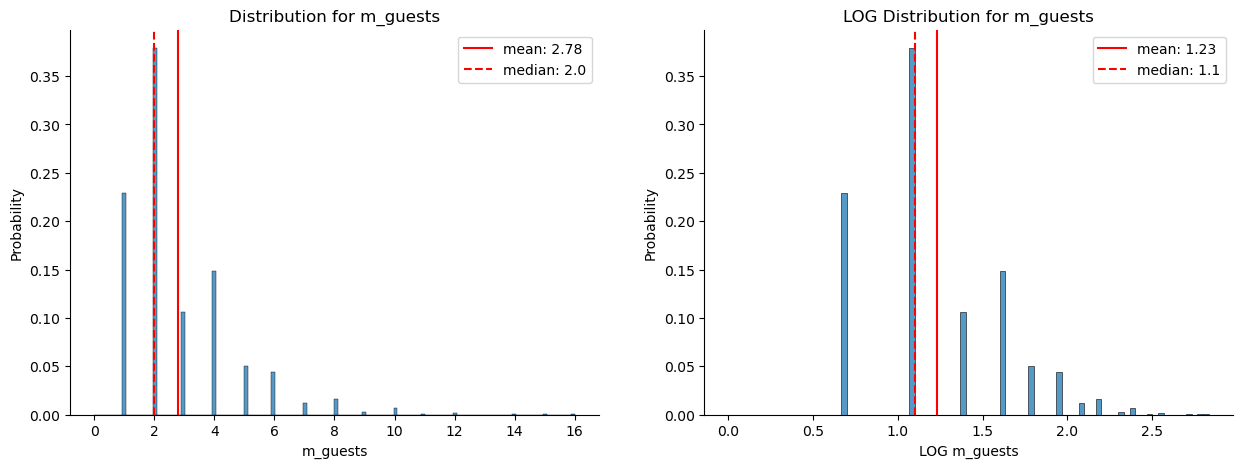

Time taken : 0.663 seconds.




In [35]:
# Examine distribution of selected column
plot_distribution(numerical_df,numerical_df.columns[0])

There was only one null value observed for the column `m_guests` which represents the number of guests the inquiry is for. Although the column is numerical, the number of guests take on distinct values, and should instead be treated as a categorical column.

In the log distribution for `m_guests`, two peaks were observed 2 and 4, with 2 being the most common number of guests for inquiries *(37.90% of all inquiries)*. A right skew was observed, meaning most inquiries had 1-4 guests. One possible explanation is that groups with more than 4 guests tend to travel through tour agencies rather than independently make accomodation bookings.

In [36]:
# Treating `m_guests` as a categorical column
categorical_value_count(numerical_df,numerical_df.columns[0]).head()

,m_guests,Counts,% of total
0,2.0,10569,37.90
1,1.0,6388,22.91
2,4.0,4135,14.83
3,3.0,2966,10.64
4,5.0,1413,5.07


In [37]:
numerical_df.describe()

,m_guests,m_interactions,m_first_message_length_in_characters,total_reviews,words_in_user_profile_guest,words_in_user_profile_host
count,27886.000000,27887.000000,27887.000000,27887.000000,27887.000000,27887.000000
mean,2.782041,8.255818,193.712626,15.665113,10.077491,53.915086
std,1.863797,10.035784,183.172132,27.752117,30.475024,102.170298
min,0.000000,1.000000,0.000000,-34.000000,0.000000,0.000000
25%,2.000000,3.000000,66.000000,0.000000,0.000000,1.000000
50%,2.000000,5.000000,154.000000,3.000000,0.000000,21.000000
75%,4.000000,10.000000,269.000000,18.000000,1.000000,63.000000
max,16.000000,410.000000,2341.000000,268.000000,658.000000,1460.000000


`m_guests`: number of guests
- most inquiries between 2 and 4 guests
- 1 null value, right skewed distribution

`m_interactions`: number of interactions in inquiry
- most interactions between 3 and 10
- no null values, right skewed distribution

`m_first_message_length_in_characters`: number of characters in inquiry sent by guest
- most guests send some message for their inquiry
- character length between 66 characters and 269 characters, about a paragraph of text
- no null values, bimodal distribution with general right skew
- - 1 group sent nothing for messages in first interaction
- - the other group sent about a paragraph's length in the first message

`total_reviews`: number of reviews for listings at the time of inquiry
- guests were willing to inquiry for listings with 0 reviews
- most listings had between 0 and 18 reviews.
- no null values, right skew with most listings have 0 reviews (31% of listings) 

`words_in_user_profile_guest`: number of words in profile of guests
- most guests do not have any words in their profiles
- expected as guests do not need to attract the attention of other guests
- no null values, right skew

`words_in_user_profile_host`: number of words in profile of hosts
- mosts hosts have between 1 and 63 words in their profiles
- expected as hosts need to attract the attention of guests to their listing
- provide more context for guests looking at listing
- no null values, right skew

===== Distribution Plots for m_guests =====
Number of null values in m_guests: 1
% null values in m_guests: 0.0%


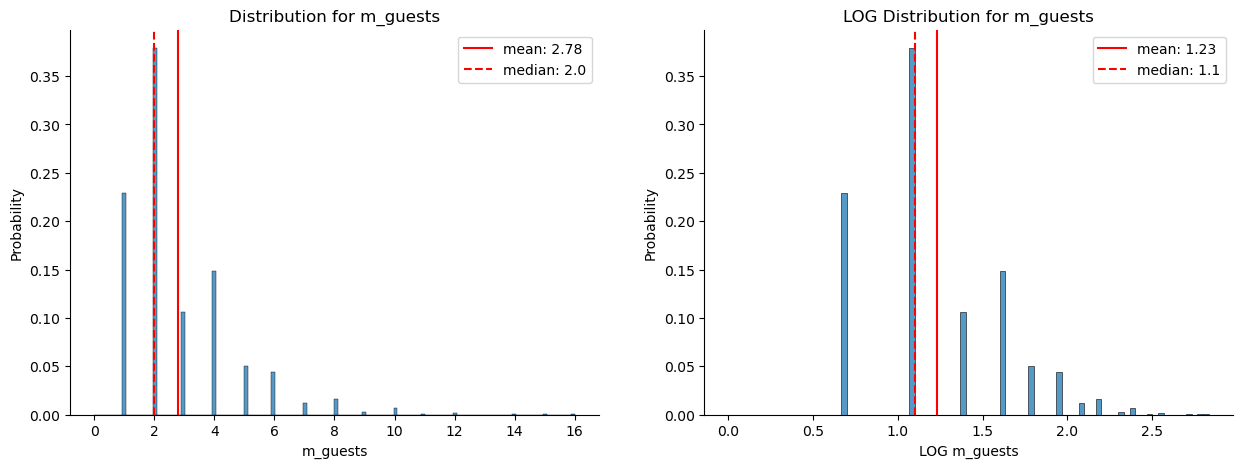

Time taken : 0.666 seconds.


===== Distribution Plots for m_interactions =====
Number of null values in m_interactions: 0
% null values in m_interactions: 0.0%


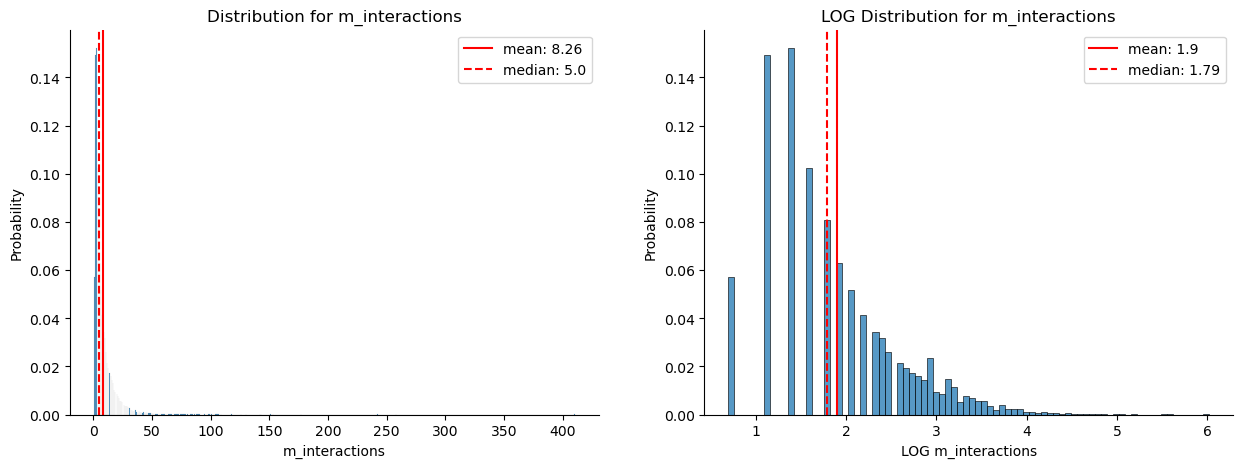

Time taken : 1.878 seconds.


===== Distribution Plots for m_first_message_length_in_characters =====
Number of null values in m_first_message_length_in_characters: 0
% null values in m_first_message_length_in_characters: 0.0%


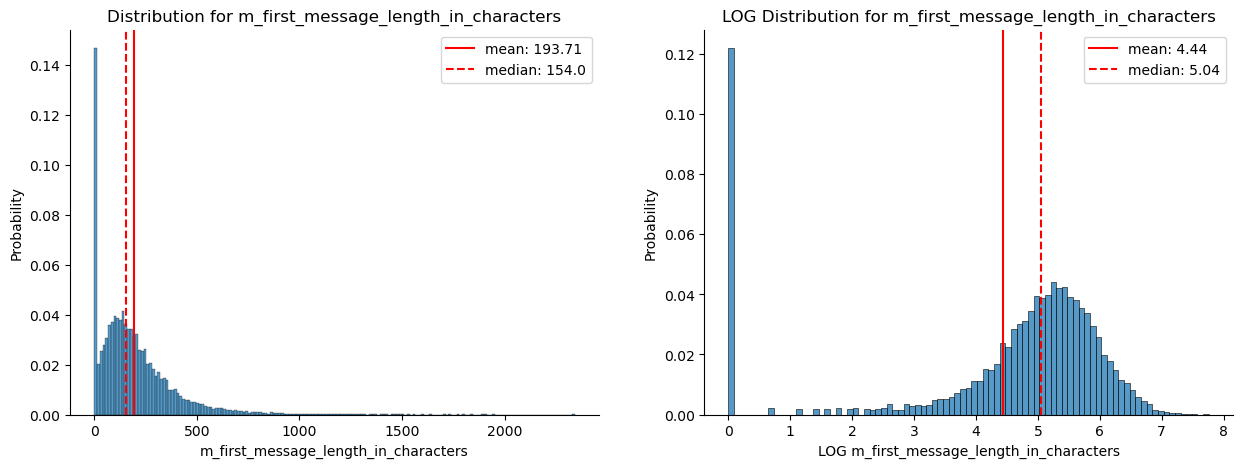

Time taken : 0.673 seconds.


===== Distribution Plots for total_reviews =====
Number of null values in total_reviews: 0
% null values in total_reviews: 0.0%


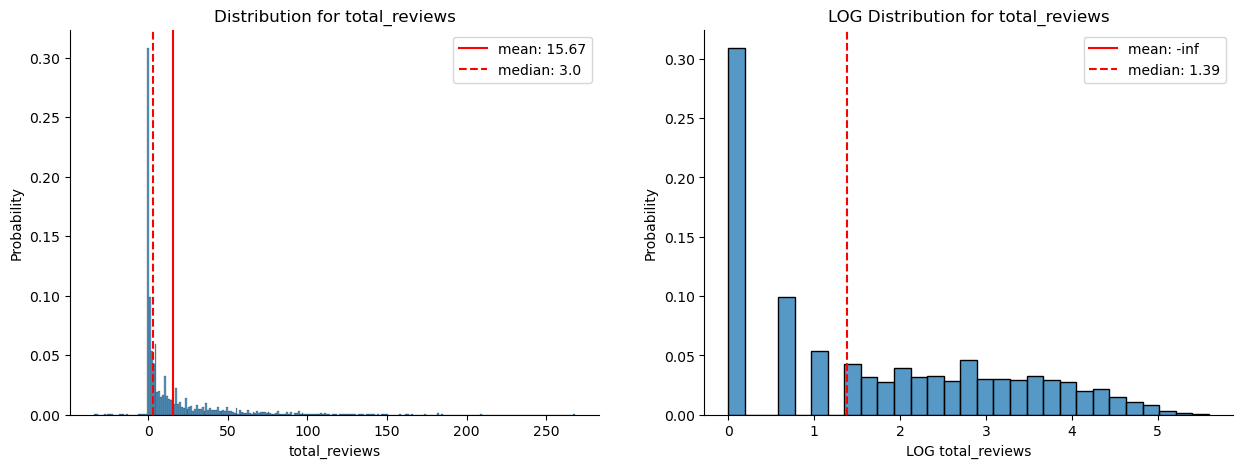

Time taken : 0.702 seconds.


===== Distribution Plots for words_in_user_profile_guest =====
Number of null values in words_in_user_profile_guest: 0
% null values in words_in_user_profile_guest: 0.0%


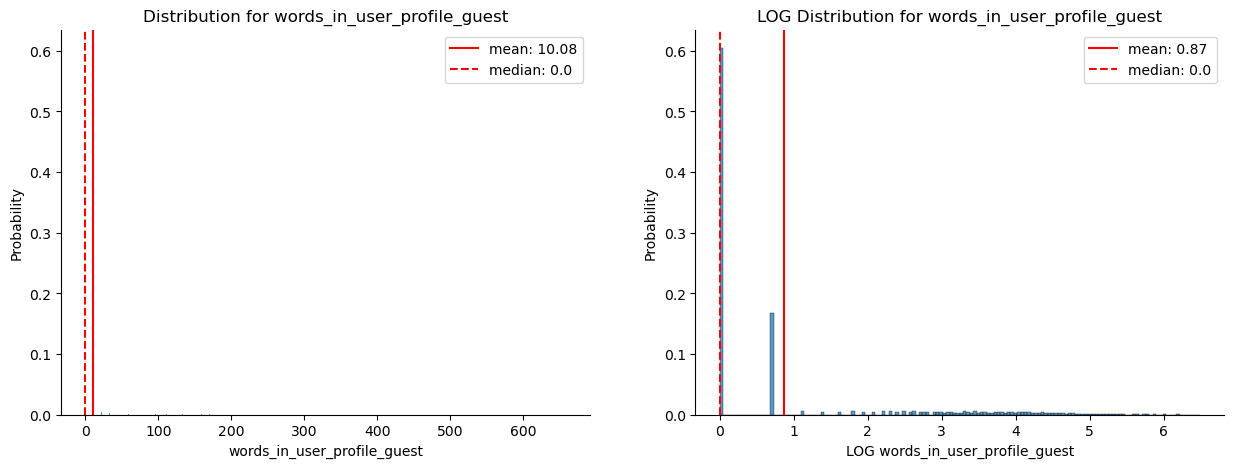

Time taken : 16.986 seconds.


===== Distribution Plots for words_in_user_profile_host =====
Number of null values in words_in_user_profile_host: 0
% null values in words_in_user_profile_host: 0.0%


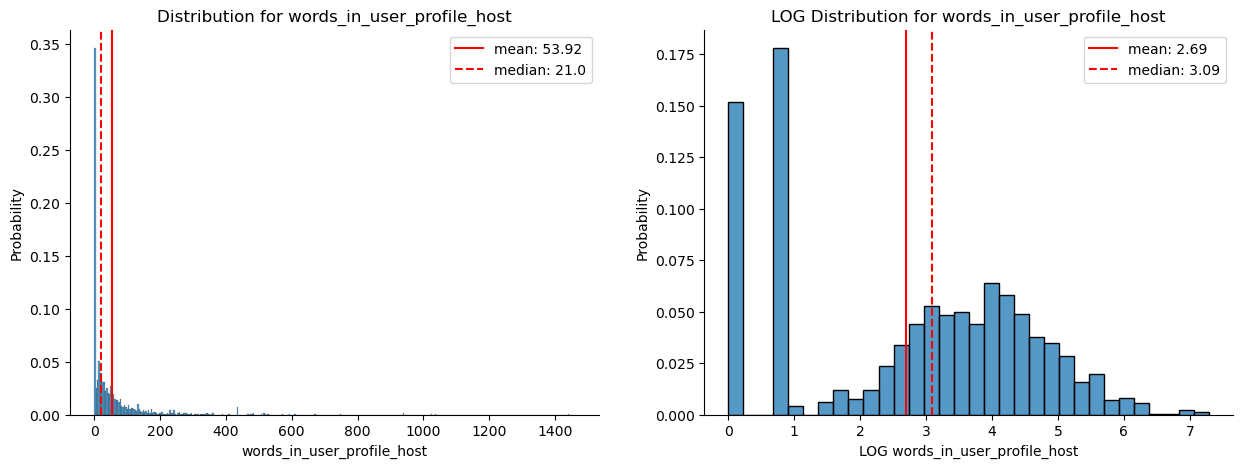

Time taken : 1.218 seconds.




In [38]:
for col in numerical_df.columns:
    plot_distribution(numerical_df,col)

### Datetime columns

In [39]:
datetime_df.describe(datetime_is_numeric = True)

,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first
count,27887,25855,16415,11587,27887,27887
mean,2016-03-23 07:24:14.375551488,2016-03-25 03:05:00.799496960,2016-03-30 16:20:44.481267200,2016-04-02 17:27:40.525761536,2016-05-31 19:56:50.492343808,2016-06-08 08:36:53.160253696
min,2016-01-01 00:46:47,2016-01-01 01:07:50,2016-01-01 12:24:15,2016-01-01 12:24:15,2016-01-01 00:00:00,2016-01-02 00:00:00
25%,2016-01-28 00:11:36.500000,2016-01-29 19:49:19,2016-02-08 19:14:27,2016-02-14 12:37:13.500000,2016-03-11 00:00:00,2016-03-18 00:00:00
50%,2016-03-18 23:15:42,2016-03-21 20:45:42,2016-03-30 12:16:14,2016-04-03 17:18:48,2016-06-11 00:00:00,2016-06-20 00:00:00
75%,2016-05-13 05:47:13,2016-05-15 13:53:14.500000,2016-05-19 12:44:38,2016-05-21 16:41:14,2016-08-08 00:00:00,2016-08-16 00:00:00
max,2016-06-30 23:58:14,2017-02-23 08:56:59,2016-11-22 11:11:12,2016-09-21 21:55:48,2018-05-01 00:00:00,2018-05-04 00:00:00


### Object columns

In [40]:
objects_df.columns

Index(['id_guest_anon', 'id_host_anon', 'id_listing_anon',
       'contact_channel_first', 'guest_user_stage_first', 'room_type',
       'listing_neighborhood', 'country_guest', 'country_host'],
      dtype='object')

In [41]:
for col in objects_df.iloc[:,3:].columns:
    display(categorical_value_count(objects_df, col).head())

,contact_channel_first,Counts,% of total
0,contact_me,12828,46.0
1,book_it,8366,30.0
2,instant_book,6693,24.0


,guest_user_stage_first,Counts,% of total
0,new,15905,57.03
1,past_booker,11947,42.84
2,-unknown-,35,0.13


,room_type,Counts,% of total
0,Entire home/apt,20981,75.24
1,Private room,6314,22.64
2,Shared room,592,2.12


,listing_neighborhood,Counts,% of total
0,-unknown-,11828,42.41
1,Copacabana,6527,23.41
2,Ipanema,2994,10.74
3,Leblon,1021,3.66
4,Barra da Tijuca,998,3.58


,country_guest,Counts,% of total
0,BR,13613,48.81
1,US,3413,12.24
2,AR,2326,8.34
3,FR,1333,4.78
4,GB,1163,4.17


,country_host,Counts,% of total
0,BR,27572,98.87
1,US,113,0.41
2,FR,40,0.14
3,GB,28,0.10
4,IT,24,0.09


## Creating metrics

Success is defined as an inquiry resulting in a booking through AirBnB. Thus, any inquiry that has a non-null value for `ts_booking_at`.

In [42]:
first_inquiry = contacts_df['ts_interaction_first'].min()
last_inquiry = contacts_df['ts_interaction_first'].max()
number_of_inquiries = contacts_df.shape[0]
inquiries_wo_booking = contacts_df['ts_booking_at'].isna().sum()


print(f"""
      Between {first_inquiry} and {last_inquiry}, 
      a total of {number_of_inquiries} inquiries were made, 
      of which {number_of_inquiries - inquiries_wo_booking} ({np.round(100-(inquiries_wo_booking/number_of_inquiries*100),2)}%) resulted in a booking.
      """)


      Between 2016-01-01 00:46:47 and 2016-06-30 23:58:14, 
      a total of 27887 inquiries were made, 
      of which 11587 (41.55%) resulted in a booking.
      


Boolean `resulted_in_booking` column:
- 1: inquiry resulted in booking through AirBnB
- 0: inquiry did not resulted in booking through Air BnB

In [44]:
# Create a Boolean column that specifies if an inquiry resulted in a booking
# if `ts_booking_at` is null, then inquiry did not result in booking
contacts_df['resulted_in_booking'] = np.where(contacts_df['ts_booking_at'].isna(),0,1)

In [50]:
# sanity check
temp_df = contacts_df.groupby(
    by = ['contact_channel_first', 'resulted_in_booking'],
    as_index = False).agg(number_of_inquiries = ('resulted_in_booking','count'))

temp_df['pct_of_inquiries'] = np.round(temp_df['number_of_inquiries']/temp_df['number_of_inquiries'].sum()*100,2)

print(f"Total Number of Inquiries: {temp_df['number_of_inquiries'].sum()}.")
temp_df.head()

Total Number of Inquiries: 27887.


,contact_channel_first,resulted_in_booking,number_of_inquiries,pct_of_inquiries
0,book_it,0,4383,15.72
1,book_it,1,3983,14.28
2,contact_me,0,11917,42.73
3,contact_me,1,911,3.27
4,instant_book,1,6693,24.00


All `instant_book` inquiries resulted in a booking, which makes sense since `instant_book` inquiries do not need to go through further review or approval of the host.

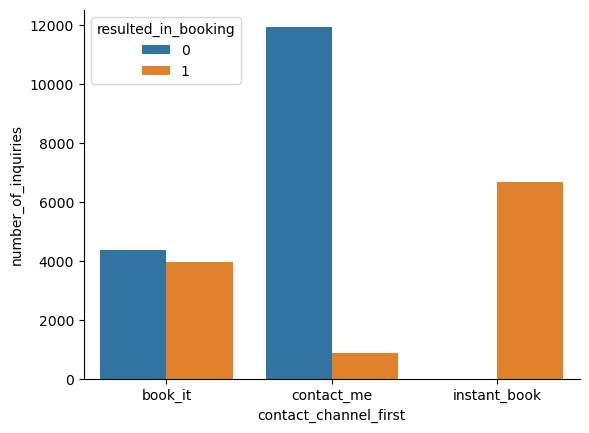

In [53]:
plt.figure()
sns.barplot(
    data = temp_df,
    x = 'contact_channel_first',
    y = 'number_of_inquiries',
    hue = 'resulted_in_booking'
)

sns.despine()
plt.show()

## Metrics

1) Inquiries by time

In [116]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

# by month

# Create a copy so as to not tamper with the clean data
temp_df = contacts_df.copy()

# Define groupings by the start of each month
grouper = pd.Grouper(
    key = 'ts_interaction_first',
    freq = 'MS'
    )

# Apply grouper object to calculate number of inquiries for each month
temp_df = temp_df.groupby(
    by = [grouper]).agg(
        inquiries = ('ts_interaction_first','count'),
        bookings = ('resulted_in_booking','sum')).reset_index()

# Calculate conversion rate from inquiries into bookings
temp_df['conversion_rate'] = np.round(temp_df['bookings'] / temp_df['inquiries']*100,2)

# Convert to ts_interaction_first to YYYYMM
temp_df['ts_interaction_first'] = temp_df['ts_interaction_first'].dt.strftime('%Y-%m')

# Display resulting table
display(temp_df)

,ts_interaction_first,inquiries,bookings,conversion_rate
0,2016-01,7618,2139,28.08
1,2016-02,4071,1796,44.12
2,2016-03,3817,1760,46.11
3,2016-04,3716,1674,45.05
4,2016-05,4304,2047,47.56
5,2016-06,4361,2171,49.78


In [118]:
# Sanity check
temp_df['inquiries'].sum() == contacts_df.shape[0]

True

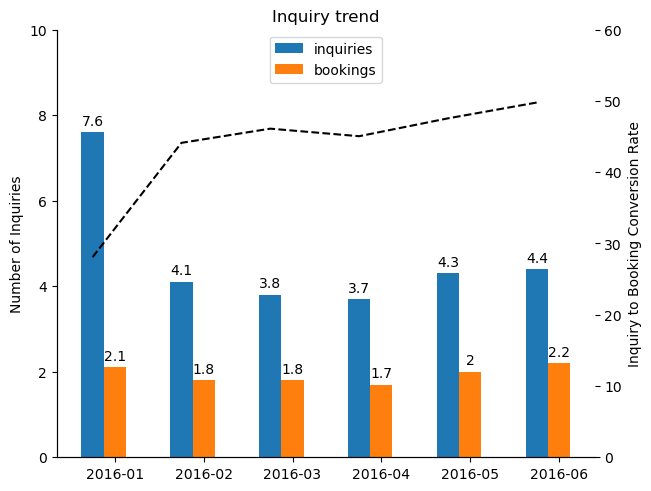

In [133]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
x = np.arange(len(temp_df['ts_interaction_first'])) # the label locations
width = 0.25 # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout = 'constrained')

for col in ['inquiries','bookings']:
    offset = width * multiplier
    rects = ax.bar(x + offset, (np.round(temp_df[col]/1000,1)), width, label = col)
    ax.bar_label(rects, padding = 3)
    multiplier +=1

    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Inquiries')
ax.set_title('Inquiry trend')
ax.set_xticks(x + width, temp_df['ts_interaction_first'])
ax.legend(loc='upper center')
ax.set_ylim(0, 10)

ax2 = plt.twinx()

sns.lineplot(
    data = temp_df,
    x = 'ts_interaction_first',
    y = 'conversion_rate',
    color = 'black',
    linestyle = '--'
    )

ax2.set_ylabel('Inquiry to Booking Conversion Rate')
ax2.set_ylim(0,60)

sns.despine()
plt.show()

| # 	| Key Metric                                              	| Reasoning                                                                                                                                   	|
|---	|---------------------------------------------------------	|---------------------------------------------------------------------------------------------------------------------------------------------	|
| 1 	| Number of Inquiries per time                            	| Represents the total possible bookings per time. <br>Increase in metric means more guests are making inquiries on AirBnB.                   	|
| 2 	| Conversion Rate of <br>Inquiries to Booking<br>per time 	| Represents the percentage of inquiries that became bookings per time.<br>Increase in metric means more guests made bookings through AirBnB. 	|

In [140]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

# by month

# Create a copy so as to not tamper with the clean data
temp_df = contacts_df.copy()

# Define groupings by the start of each month
grouper = pd.Grouper(
    key = 'ts_interaction_first',
    freq = 'MS'
    )

# Apply grouper object to calculate number of inquiries for each month
temp_df = temp_df.groupby(
    by = [grouper,'contact_channel_first']).agg(
        inquiries = ('ts_interaction_first','count'),
        bookings = ('resulted_in_booking','sum')).reset_index()

# Calculate conversion rate from inquiries into bookings
temp_df['conversion_rate'] = np.round(temp_df['bookings'] / temp_df['inquiries']*100,2)

# Convert to ts_interaction_first to YYYYMM
temp_df['ts_interaction_first'] = temp_df['ts_interaction_first'].dt.strftime('%Y-%m')

# Display resulting table
display(temp_df.head())

,ts_interaction_first,contact_channel_first,inquiries,bookings,conversion_rate
0,2016-01,book_it,2371,908,38.30
1,2016-01,contact_me,4228,212,5.01
2,2016-01,instant_book,1019,1019,100.00
3,2016-02,book_it,1291,667,51.67
4,2016-02,contact_me,1798,147,8.18


In [138]:
temp_df.group()

,ts_interaction_first,contact_channel_first,inquiries,bookings
0,2016-01-01,book_it,2371,908
1,2016-01-01,contact_me,4228,212
2,2016-01-01,instant_book,1019,1019
3,2016-02-01,book_it,1291,667
4,2016-02-01,contact_me,1798,147
5,2016-02-01,instant_book,982,982
6,2016-03-01,book_it,1200,655
7,2016-03-01,contact_me,1640,128
8,2016-03-01,instant_book,977,977
9,2016-04-01,book_it,1127,569


In [ ]:
cond1 = contacts_df[]

In [ ]:
contacts_df.groupby(by = [''])

In [ ]:
contacts_df.head(3).T

In [ ]:
contacts_df['contact_channel_first'].unique()

In [ ]:
cond1 = contacts_df['contact_channel_first'] == 'instant_book'

temp_df = contacts_df.loc[cond1]

print(f"Number of inquiries that were `instant_book`: {temp_df.shape[0]}")
temp_df.head()

In [ ]:
# verify if date columns are equal
temp_df.isna().sum()

In [ ]:
# Define condition to find singular host with no user country of origin information
cond1 = contacts_df['country_host'].isnull()

# Visually examine the host with no country of origin information
contacts_df[cond1]

In [ ]:
contacts_df.isna().any(axis = 1).sum()

In [ ]:
contacts_df.

In [ ]:
contacts_df.info()

![Airbnb](https://raw.githubusercontent.com/interviewquery/takehomes/airbnb_1/airbnb_1/logo.png)

# TAKE-HOME CHALLENGE: Data Science - Analytics

Airbnb is a two-sided marketplace that matches guests to hosts. The
booking flow at Airbnb is as follows: a guest finds an available room
(listing) that they like, and then they contact the host. Once the guest
finds a listing they are interested in, there are three ways to send the
host an inquiry: `contact_me`, `book_it`, or `instant_book` (detailed at
the bottom of this document). Upon receiving the inquiry, the host can
then decide whether or not to accept the request (for `contact_me` and
`book_it` methods; `instant_book` is auto-accepted). One of our
goals at Airbnb is to increase bookings on our platform.

## Prompt

You are the first data scientist to join a cross-functional Product and
Operations team working to grow bookings in Rio de Janeiro. The team
asks you for help with the following:

1.  What key metrics would you propose to monitor over time the success
    of the team's efforts in improving the guest host matching process
    and why? Clearly define your metric(s) and explain how each is
    computed.

2.  What areas should we invest in to increase the number of successful
    bookings in Rio de Janeiro? What segments are doing well and what
    could be improved? ​ ​Propose 2-3 specific recommendations (business
    initiatives and product changes) that could address these
    opportunities. Demonstrate rationale behind each recommendation AND
    prioritize your recommendations in order of their estimated impact.

3.  There is also interest from executives at Airbnb in the work you
    are doing, and a desire to understand the broader framing of the
    challenge of matching supply and demand, thinking beyond the data
    provided. What other research, experiments, or approaches could help
    the company get more clarity on the problem?

## Assignment 
S​ummarize your recommendations in response to the questions above in a Jupyter Notebook intended for
the Head of Product and VP of Operations (who is not technical). Include
an organized appendix sharing the details of your work conducted for the
Rio team, that would be useful for the data team to understand your
work.






## Grading

Your assignment will be judged according to:

1.  The analytical approach and clarity of your graphs, tables,
    visualizations,

2.  The data decisions you made and reproducibility of the analysis,

3.  Strength of recommendations, prioritizations, and rationale behind
    those,

4.  The narrative of your presentation and ability to effectively
    communicate to non-technical executives, 5) How well you followed
    the directions.

## Data Provided

### `contacts.csv`​​ 
Contains a row for every time that a user makes an
inquiry for a stay at a listing in Rio de Janeiro.

-   *id col ignore* `id_guest_anon` -​ id of the guest making the inquiry.

-   *id col ignore* `id_host_anon` -​ id of the host of the listing to which the inquiry is
    made.

-   *id col ignore* `id_listing_anon` -​ id of the listing to which the inquiry is made.

-   *id col ignore* `ts_interaction_first` -​ UTC timestamp of the moment the inquiry is
    made.

-   `ts_reply_at_first` -​ UTC timestamp of the moment the host replies to
    the inquiry, if so. 
- `ts_accepted_at_first` - UTC timestamp of the
    moment the host accepts the inquiry, if so.​ 
    
-    `ts_booking_at` - UTC
    timestamp of the moment the booking is made, if so.

-   `ds_checkin_first` -​ Date stamp of the check-in date of the inquiry.

-   `ds_checkout_first` ​- Date stamp of the check-out date of the inquiry.

-   `m_guests` ​- The number of guests the inquiry is for.

-   `m_interactions` -​ The total number of messages sent by both the guest
    and host.

-   `m_first_message_length_in_characters` -​ Number of characters in the
    first message sent by the guest, if a message was sent

-   `contact_channel_first` -​ The contact channel through which the
    inquiry was made. One of {contact_me, book_it, instant_book}. \*See
    bottom of page for more detail\*

-   `guest_user_stage_first` ​- Indicates whether the user has made a
    booking before sending the inquiry ("past booker"). If the user has
    not booked before, then the user is a new user.

### `listings.csv`
Contains data for every listing in the market

-   `id_listing_anon` ​- anonymized id of the listing

-   `room_type` -​ indicates whether the room is an entire home, private
    room, or shared room

-   `listing_neighborhood` -​ the neighborhood of the listing

-   `total_reviews` -​ the total number of reviews of the listing (at the
    time the data was pulled).

### Users
Contains data for every user

-   `id_user_anon` ​- anonymized id of user

-   `words_in_user_profile` - the number of words in the "about me"
    section of the user's Airbnb profile (at the time of contact)

-   `country` -​ origin country of the user

## Further Information

There are three ways to book a listing on Airbnb:

1)  `contact_me` -​ The guests writes a message to the host to inquire
    about the listing. The host has the option to 1) pre-​approve the
    guest to book their place, or 2) they can reject, or 3) they can
    write a free text message with no explicit acceptance or rejection.
    If the host pre-​approves, the guest can then go ahead and click to
    make the booking (but is not obligated to).

2)  `book_it` ​- The guest puts money down to book the place directly,
    but the host has to accept the reservation request. If the host
    accepts, the booking happens automatically. If you have used Airbnb
    before, this shows up as a button labeled "Request to book".

3)  `instant_book`​ -​ The guest books the listing directly, without any
    need for the host to accept or reject actively (it is auto​-accepted
    by the host). This shows up as a button labeled "Book".

### Note​ 
A host can opt-in to the `instant_book` feature. If a host
does so, a guest can use the `contact_me` or `instant_book` channels
for booking that particular listing, but cannot use the `book_it`
functionality. Alternatively, if a host does not opt in, a guest can use
the `contact_me` or `book_it` channels only. We suggest that you
browse the Airbnb website and look at listings to see the different ways
that you can message a host.
